In [7]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy.misc import imsave
from sklearn.cluster import KMeans
import imageio

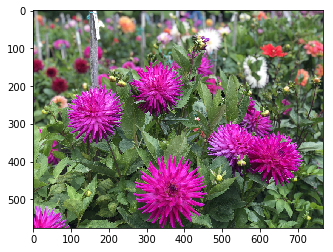

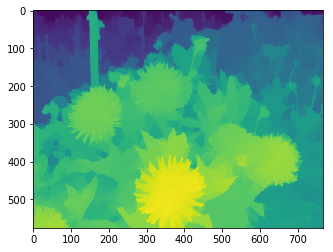

In [4]:
depth = cv2.imread("IMG_1439.depth.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.imread("IMG_1439.jpg")
img = cv2.resize(img, (depth.shape[1], depth.shape[0]))
img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
plt.imshow(img)
plt.show()
plt.imshow(depth)

# White-Out
First, we'll make a gif of the scene appearing from near to far.

In [107]:
numFrames = 20

# The first thing we'll do is segment the depth channel using k-means. 
# This will tell us roughly where to slice the depth channel.
kmeans = KMeans(n_clusters=numFrames, random_state=0).fit(depth.flatten().reshape(-1, 1))

In [108]:
# We'll sort the centers so they are in order of depth
centers = kmeans.cluster_centers_.flatten()
centers.sort()
centers

array([ 11.76700989,  26.46533905,  40.64642951,  54.40345637,
        68.53231045,  82.99505493,  97.5547367 , 112.50326531,
       128.64753883, 137.94773736, 146.7006494 , 157.49133293,
       165.71635792, 173.38305674, 181.35752145, 189.32064693,
       199.67944273, 212.65403197, 227.03506908, 244.61838574])

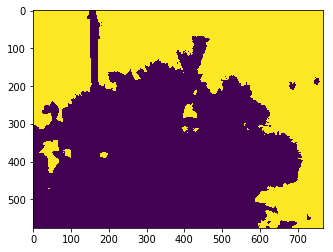

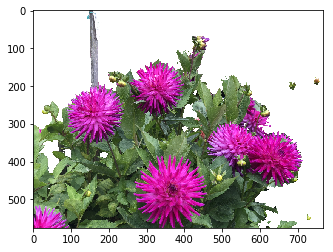

In [109]:
# Now, any pixels less than some specific centroid are farther away. 
# You can visualize a specific center with a mask
mask = depth < centers[numFrames / 2]
frame = img.copy()
frame[mask] = 255
plt.imshow(mask)
plt.show()
plt.imshow(frame)

In [110]:
# Finally, we'll make a white-out image with each different center
frames = []
for c in centers:
    frame = img.copy()
    frame[depth < c] = 255
    frames.append(frame)
frames.append(np.ones(img.shape, img.dtype) * 255)
frames = list(reversed(frames))
frames.append(img)

In [111]:
# And save it as a gif
imageio.mimsave('white-out.gif', frames, fps = int(len(frames)/3), subrectangles = True)

# Moving Scene
Next, we'll fake a visualization of a 3d scene where we pan the closer items at a different speed.

In [163]:
# Let's use fewer frames this time..
numFrames = 3
zoom = 1.5
kmeans = KMeans(n_clusters=numFrames, random_state=0).fit(depth.flatten().reshape(-1, 1))
centers = kmeans.cluster_centers_.flatten()
centers.sort()
centers

array([ 64.72241135, 151.4073615 , 203.15550889])

In [164]:
# This function:
# 1. generates a mask based on the depth limit
# 2. in-paints everything behind the depth limit
# 3. cuts out anything in front of the depth limit
def genImages(img, depth, limit):
    # Generate a mask based on a depth limit
    mask = depth > limit
    inpainted = cv2.inpaint(img, mask.astype(np.uint8), 10, cv2.INPAINT_TELEA)
    
    # make an image with transparency.
    trans = np.zeros((img.shape[0], img.shape[1], 4), np.uint8)
    trans[:,:,0:3] = img
    trans[mask, 3] = 255
    
    return (mask, trans, inpainted)

In [183]:
frames = []
for i, c in enumerate(centers):
    frames.append(genImages(img, depth, c))

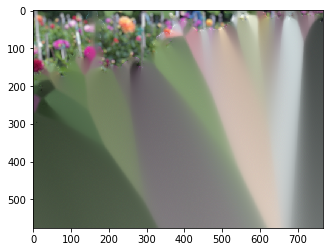

In [184]:
plt.imshow(frames[0][2])

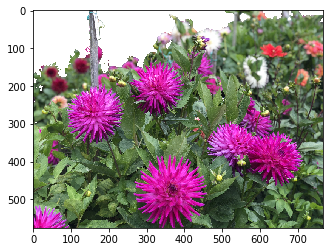

In [185]:
plt.imshow(frames[0][1])

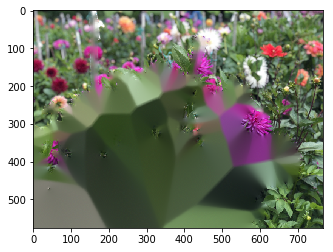

In [186]:
plt.imshow(frames[1][2])

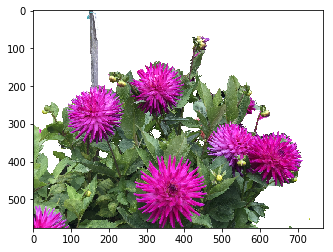

In [187]:
plt.imshow(frames[1][1])

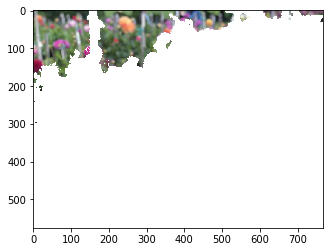

In [195]:
l = frames[1][2].copy()
l[frames[0][0]] = 255
plt.imshow(l)
# frames[1][2][frames[0][0]] = 255
# plt.imshow(frames[1][2])